In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def json_to_2_lists(json_file):
  with open(json_file) as f:
    data = json.load(f)
  neg_scores = []
  pos_scores = []
  for document in data:
    neg_scores.append(document["average_negative_score"]["value"])
    pos_scores.append(document["average_positive_score"]["value"])
  return neg_scores, pos_scores

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PEDRO_SANCHEZ_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/0101_0630_splitted.json'
OBRADOR_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/262.json'
FIGUERES_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/555.json'
CHAVES_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/609.json'
MENORCA_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/1803.json'

sanchez_negative_scores, sanchez_positive_scores = json_to_2_lists(PEDRO_SANCHEZ_PATH)
obrador_negative_scores, obrador_positive_scores = json_to_2_lists(OBRADOR_PATH)
figueres_negative_scores, figueres_positive_scores = json_to_2_lists(FIGUERES_PATH)
chaves_negative_scores, chaves_positive_scores = json_to_2_lists(CHAVES_PATH)
menorca_negative_scores, menorca_positive_scores = json_to_2_lists(MENORCA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sanchez_scores = np.array(sanchez_positive_scores) - np.array(sanchez_negative_scores)
print(f'Pedro Sánchez: {len(sanchez_scores)}')

obrador_scores = np.array(obrador_positive_scores) - np.array(obrador_negative_scores)
print(f'Obrador: {len(obrador_scores)}')

figueres_scores = np.array(figueres_positive_scores) - np.array(figueres_negative_scores)
print(f'Figueres: {len(figueres_scores)}')

chaves_scores = np.array(chaves_positive_scores) - np.array(chaves_negative_scores)
print(f'Chaves: {len(chaves_scores)}')

menorca_scores = np.array(menorca_positive_scores) - np.array(menorca_negative_scores)
print(f'Menorca: {len(menorca_scores)}')

Pedro Sánchez: 682
Obrador: 1373
Figueres: 1214
Chaves: 1192
Menorca: 284


In [ ]:
def min_max_normalization(value, max_value, min_value):
    """Normalize value between 0-1

    :param value: int/float
    :param max_value: int/float max value
    :param min_value: int/float min value
    :return: float
    """
    # Remove negative values shifting the minimum value
    value_shift = abs(min_value)
    max_value += value_shift
    min_value += value_shift
    value += value_shift

    divisor = max_value - min_value
    if divisor == 0:
        # Avoid division by zero, return the center
        return 1 / 2

    # Normalize value
    normalized_value = (value - min_value) / divisor

    return normalized_value

In [ ]:
def calculate_nsi(positive_score, negative_score, min_nsi=20, max_nsi=90, **kwargs):
    """Calculate NSI from normalized sentiment score

    :param positive_score: float
    :param negative_score: float
    :param min_nsi: int/float minimum nsi value
    :param max_nsi: int/float maximum nsi value
    :param positive_factor: float positive factor
    :param negative_factor: float negative factor
    :return: float
    """
    # Set default positive score
    if not positive_score:
        positive_score = 0

    # Set default negative score
    if not negative_score:
        negative_score = 0

    # Boost negative score
    positive_factor = 1

    negative_factor = 1.2

    positive_score *= positive_factor
    negative_score *= negative_factor

    # Calculate nsi
    sentiment_score = positive_score - negative_score
    sentiment_score = min_max_normalization(sentiment_score, positive_score, -negative_score)

    # Scale nsi from 0-1 to 0-100
    return (sentiment_score * (max_nsi - min_nsi)) + min_nsi

In [ ]:
old_nsi = np.vectorize(calculate_nsi)

In [ ]:
def sigmoid (x, A, h, slope, C):
    return A/(1 + np.exp(-x*slope + h)) + C

In [ ]:
# Sigmoid parameters
A = 100 # we want values from 0 to 100
h = 0 # bring down the center of the curve (if score=0 -> NSI<50 if h>0)
slope = 5 # the higher the slope, the higher the variance around score 0
C = 0 # we don't want a vertical offset

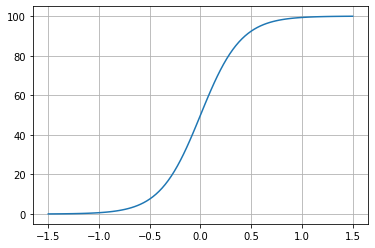

0.6692850924284856 50.0 99.33071490757152


In [ ]:
x_plot = np.linspace(-1.5, 1.5, 100)
new_nsi = np.vectorize(sigmoid)
y_plot = new_nsi(x_plot, A, h, slope, C)
plt.plot(x_plot, y_plot)
plt.grid()
plt.show()
print(sigmoid(-1, A, h, slope, C), sigmoid(0, A, h, slope, C), sigmoid(1, A, h, slope, C))

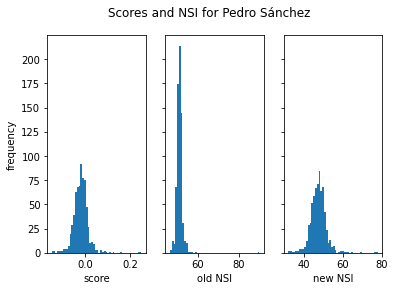

Median score: -0.02
95% confidence interval for scores: [-0.09, 0.04]
Median old NSI: 51.01
95% confidence interval for old NSI: [48.37, 53.59]
Median new NSI: 47.5
95% confidence interval for new NSI: [39.06, 55.21]


In [ ]:
sanchez_old_NSI = old_nsi(sanchez_positive_scores, sanchez_negative_scores)
sanchez_new_NSI = new_nsi(sanchez_scores, A, h, slope, C)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.hist(sanchez_scores, bins=50)
ax2.hist(sanchez_old_NSI, bins=50)
ax3.hist(sanchez_new_NSI, bins=50)
fig.suptitle("Scores and NSI for Pedro Sánchez")
ax1.set_xlabel("score")
ax2.set_xlabel("old NSI")
ax3.set_xlabel("new NSI")
ax1.set_ylabel("frequency")
plt.show()

print(f'Median score: {round(np.median(sanchez_scores), 2)}')
print(f'95% confidence interval for scores: [{round(np.percentile(sanchez_scores, 2.5), 2)}, {round(np.percentile(sanchez_scores, 97.5), 2)}]')
print(f'Median old NSI: {round(np.median(sanchez_old_NSI), 2)}')
print(f'95% confidence interval for old NSI: [{round(np.percentile(sanchez_old_NSI, 2.5), 2)}, {round(np.percentile(sanchez_old_NSI, 97.5), 2)}]')
print(f'Median new NSI: {round(np.median(sanchez_new_NSI), 2)}')
print(f'95% confidence interval for new NSI: [{round(np.percentile(sanchez_new_NSI, 2.5), 2)}, {round(np.percentile(sanchez_new_NSI, 97.5), 2)}]')

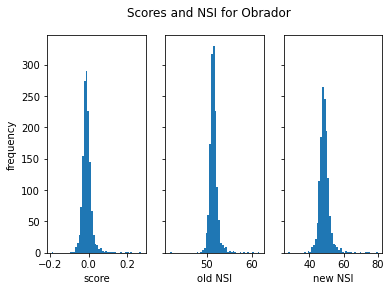

Median score: -0.01
95% confidence interval for scores: [-0.05, 0.05]
Median old NSI: 51.39
95% confidence interval for old NSI: [50.0, 53.53]
Median new NSI: 48.54
95% confidence interval for new NSI: [43.52, 55.84]


In [ ]:
obrador_old_NSI = old_nsi(obrador_positive_scores, obrador_negative_scores)
obrador_new_NSI = new_nsi(obrador_scores, A, h, slope, C)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.hist(obrador_scores, bins=50)
ax2.hist(obrador_old_NSI, bins=50)
ax3.hist(obrador_new_NSI, bins=50)
fig.suptitle("Scores and NSI for Obrador")
ax1.set_xlabel("score")
ax2.set_xlabel("old NSI")
ax3.set_xlabel("new NSI")
ax1.set_ylabel("frequency")
plt.show()

print(f'Median score: {round(np.median(obrador_scores), 2)}')
print(f'95% confidence interval for scores: [{round(np.percentile(obrador_scores, 2.5), 2)}, {round(np.percentile(obrador_scores, 97.5), 2)}]')
print(f'Median old NSI: {round(np.median(obrador_old_NSI), 2)}')
print(f'95% confidence interval for old NSI: [{round(np.percentile(obrador_old_NSI, 2.5), 2)}, {round(np.percentile(obrador_old_NSI, 97.5), 2)}]')
print(f'Median new NSI: {round(np.median(obrador_new_NSI), 2)}')
print(f'95% confidence interval for new NSI: [{round(np.percentile(obrador_new_NSI, 2.5), 2)}, {round(np.percentile(obrador_new_NSI, 97.5), 2)}]')

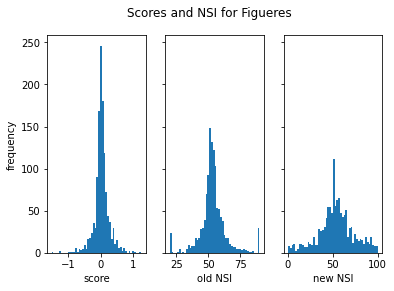

Median score: 0.02
95% confidence interval for scores: [-0.5, 0.51]
Median old NSI: 52.99
95% confidence interval for old NSI: [28.62, 84.2]
Median new NSI: 53.11
95% confidence interval for new NSI: [7.59, 92.77]


In [ ]:
figueres_old_NSI = old_nsi(figueres_positive_scores, figueres_negative_scores)
figueres_new_NSI = new_nsi(figueres_scores, A, h, slope, C)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.hist(figueres_scores, bins=50)
ax2.hist(figueres_old_NSI, bins=50)
ax3.hist(figueres_new_NSI, bins=50)
fig.suptitle("Scores and NSI for Figueres")
ax1.set_xlabel("score")
ax2.set_xlabel("old NSI")
ax3.set_xlabel("new NSI")
ax1.set_ylabel("frequency")
plt.show()

print(f'Median score: {round(np.median(figueres_scores), 2)}')
print(f'95% confidence interval for scores: [{round(np.percentile(figueres_scores, 2.5), 2)}, {round(np.percentile(figueres_scores, 97.5), 2)}]')
print(f'Median old NSI: {round(np.median(figueres_old_NSI), 2)}')
print(f'95% confidence interval for old NSI: [{round(np.percentile(figueres_old_NSI, 2.5), 2)}, {round(np.percentile(figueres_old_NSI, 97.5), 2)}]')
print(f'Median new NSI: {round(np.median(figueres_new_NSI), 2)}')
print(f'95% confidence interval for new NSI: [{round(np.percentile(figueres_new_NSI, 2.5), 2)}, {round(np.percentile(figueres_new_NSI, 97.5), 2)}]')

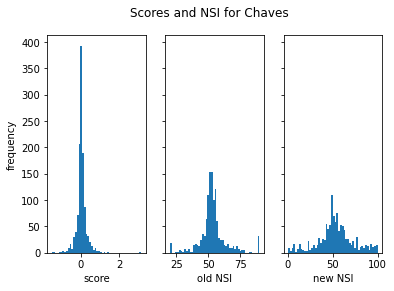

Median score: 0.02
95% confidence interval for scores: [-0.5, 0.62]
Median old NSI: 52.75
95% confidence interval for old NSI: [29.88, 90.0]
Median new NSI: 52.27
95% confidence interval for new NSI: [7.59, 95.79]


In [ ]:
chaves_old_NSI = old_nsi(chaves_positive_scores, chaves_negative_scores)
chaves_new_NSI = new_nsi(chaves_scores, A, h, slope, C)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.hist(chaves_scores, bins=50)
ax2.hist(chaves_old_NSI, bins=50)
ax3.hist(chaves_new_NSI, bins=50)
fig.suptitle("Scores and NSI for Chaves")
ax1.set_xlabel("score")
ax2.set_xlabel("old NSI")
ax3.set_xlabel("new NSI")
ax1.set_ylabel("frequency")
plt.show()

print(f'Median score: {round(np.median(chaves_scores), 2)}')
print(f'95% confidence interval for scores: [{round(np.percentile(chaves_scores, 2.5), 2)}, {round(np.percentile(chaves_scores, 97.5), 2)}]')
print(f'Median old NSI: {round(np.median(chaves_old_NSI), 2)}')
print(f'95% confidence interval for old NSI: [{round(np.percentile(chaves_old_NSI, 2.5), 2)}, {round(np.percentile(chaves_old_NSI, 97.5), 2)}]')
print(f'Median new NSI: {round(np.median(chaves_new_NSI), 2)}')
print(f'95% confidence interval for new NSI: [{round(np.percentile(chaves_new_NSI, 2.5), 2)}, {round(np.percentile(chaves_new_NSI, 97.5), 2)}]')

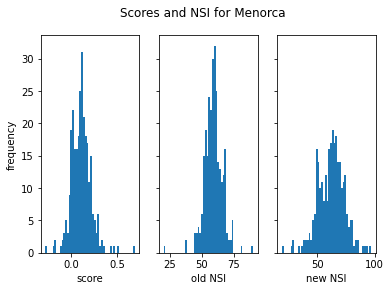

Median score: 0.11
95% confidence interval for scores: [-0.09, 0.32]
Median old NSI: 59.04
95% confidence interval for old NSI: [46.26, 73.06]
Median new NSI: 62.99
95% confidence interval for new NSI: [39.39, 83.06]


In [ ]:
menorca_old_NSI = old_nsi(menorca_positive_scores, menorca_negative_scores)
menorca_new_NSI = new_nsi(menorca_scores, A, h, slope, C)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.hist(menorca_scores, bins=50)
ax2.hist(menorca_old_NSI, bins=50)
ax3.hist(menorca_new_NSI, bins=50)
fig.suptitle("Scores and NSI for Menorca")
ax1.set_xlabel("score")
ax2.set_xlabel("old NSI")
ax3.set_xlabel("new NSI")
ax1.set_ylabel("frequency")
plt.show()

print(f'Median score: {round(np.median(menorca_scores), 2)}')
print(f'95% confidence interval for scores: [{round(np.percentile(menorca_scores, 2.5), 2)}, {round(np.percentile(menorca_scores, 97.5), 2)}]')
print(f'Median old NSI: {round(np.median(menorca_old_NSI), 2)}')
print(f'95% confidence interval for old NSI: [{round(np.percentile(menorca_old_NSI, 2.5), 2)}, {round(np.percentile(menorca_old_NSI, 97.5), 2)}]')
print(f'Median new NSI: {round(np.median(menorca_new_NSI), 2)}')
print(f'95% confidence interval for new NSI: [{round(np.percentile(menorca_new_NSI, 2.5), 2)}, {round(np.percentile(menorca_new_NSI, 97.5), 2)}]')